<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/FDM_FEM_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Difference and Finite Element Method for 1D Poisson

After this exercise, students should be able to

*   Understand the difference between two numerical methods to solve a PDE: Finite Different Method and FInite Element Method.
*   Explain two concepts: strong and weak solutions of a PDE.
*   Bring two methods to practice.

We consider 1D Poisson
$$-u''=f\,\qquad x\in(a, b)$$
with Dirichlet boundary conditions $u(a)=u_a$ and $u(b)=u_b$
where $u_a$ and $u_b$ are given.

We will find the strong solution of the equation by the Finite Difference Method and weak solution by the Finite Element Method.

First, we discretize the domain $[a, b]$ into $N-1$ subintervals by $N$ grid points $\{x_k\}_{k=0..N-1}$, $x_0=a$ and $x_{N-1}=b$. A uniform discretization is used here for the simplicity and assume that  $u^k=u(x_k)$. 


**Finite Difference Method** (FDM) uses the appproximation
$$u''\approx\frac{u^{k+1}-2u^{k}+u^{k-1}}{h^2}$$
The discretized equation
$$-\frac{u^{k+1}-2u^{k}+u^{k-1}}{h^2}=f^k, \qquad k=1..N-2$$
Matrix form
$$-\frac{1}{h^2}\begin{bmatrix} - & - &  & \\  1 & -2 & 1\\ & 1 & -2 & 1  \\&&&...\\ & &  & 1 & -2 & 1 \\ & & &  & 1 & -2 & 1 \\ & & &  &  & - & - 
\end{bmatrix}\begin{bmatrix}  u^0 \\ u^1 \\ u^2 \\ ... \\ u^{N-3}\\ u^{N-2} \\ u^{N-1}\end{bmatrix}  = \begin{bmatrix}  f^0 \\ f^1 \\ f^2 \\ ... \\ f^{N-3}\\ f^{N-2} \\ f^{N-1}\end{bmatrix}$$

Apply the Dirichlet boundary conditions $u^0=u_a, u^{N-1}=u_b$

$$\begin{bmatrix} 1 &  &  & \\  -\frac{1}{h^2} & \frac{2}{h^2} & -\frac{1}{h^2}\\ & -\frac{1}{h^2} & \frac{2}{h^2} & -\frac{1}{h^2}  \\&&&...\\ & &  & -\frac{1}{h^2} & \frac{2}{h^2} & -\frac{1}{h^2} \\ & & &  & -\frac{1}{h^2} & \frac{2}{h^2} & -\frac{1}{h^2} \\ & & &  &  &  & 1 
\end{bmatrix}\begin{bmatrix}  u^0 \\ u^1 \\ u^2 \\ ... \\ u^{N-3}\\ u^{N-2} \\ u^{N-1}\end{bmatrix}  = \begin{bmatrix}  u_a \\ f^1 \\ f^2 \\ ... \\ f^{N-3}\\ f^{N-2}\\u_b\end{bmatrix}$$



In [0]:
def FDM(f, a, b, N, u_bc):
# Solving -u''=f in (a, b) by Finite Difference Method 
# Dirichlet boundary conditions at two ending points
# Van-Dang Nguyen 2019  
  xd= np.linspace(a, b, num=N)
  # Grid size
  h=xd[1]-xd[0]
  ones=np.ones(N)

  # Create left-hand side digonal matrix [1 -2 1]
  data = -1/(h*h)*np.array([ones,-2*ones,ones])
  diags = np.array([-1, 0, 1])
  A=spdiags(data, diags, N, N,format="csr").toarray()
   
  # Boundary conditions for the left-hand side 
  A[0,:] = 0; # zero out row 0 corresponding to x=a.
  A[0,0]=1
  A[N-1,:]=0; # zero out row N-1 corresponding to x=b.
  A[N-1,N-1]=1
  
  # Boundary conditions for the right-hand side  
  lam_f = sp.lambdify(x, f, modules=['numpy'])
  rhs = lam_f(xd); # rhs = source 
  rhs[0], rhs[N-1]=u_bc(xd[0]), u_bc(xd[N-1]) # Dirichlet values
  
  ## solving the linear system
  u= spsolve(A, rhs, permc_spec=None, use_umfpack=True)
  return xd, u

**Finite Element Method** gives the weak solutions. Here we illustrate how to find the finite solution of the equation in a linear space.

On each element (sub-interval) $[x_k, x_{k+1}]$ with $h_k=|x_{k+1}-x_k|$, $u$ can be approximated by  a linear function

$u(x)\approx -\frac{1}{h_k}u^k(x-x_{k+1})+\frac{1}{h_k}u^{k+1}(x-x_k)=u^k\varphi_{k,0}(x)+u^{k+1}\varphi_{k,1}(x)$

$\varphi_{k}(x)$ is known as a linear basis function in FEM literature, 

$$
\varphi_{k,0}(x)=-\frac{1}{h_k}(x-x_{k+1}) , \quad \varphi_{k,1}(x)=\frac{1}{h_k}(x-x_{k}) 
$$

Multiply both sides of the equation with a test function $v$, and integrate 

$$\int_{x_k}^{x_{k+1}} -u'' v\, dx = \int_{x_k}^{k+1} f v \,dx$$

$$-u'v\,\biggl|_{x^k}^{x_{k+1}}+\int_{x_k}^{x_{k+1}} u' v'\, dx = \int_{x_k}^{x_{k+1}} f \,v \,dx$$

Let $q_k=u'(x_k)\,v(x_k)$, we have 
$$-q_{k+1}+q_{k}+u^k\int_{x_k}^{x_{k+1}} \varphi_{k,0}'\, v'\, dx +u^{k+1}\int_{x_k}^{x_{k+1}} \varphi_{k,1}'\, v'\, dx = \int_{x_k}^{x_{k+1}} f \,v \,dx$$

It is enough to test with $v=\varphi_{k,j}, \quad j=0,1$

* $j=0$,
$$u^k\int_{x_k}^{x_{k+1}} \varphi_{k,0}'\, \varphi_{k,0}'\, dx +u^{k+1}\int_{x_k}^{x_{k+1}} \varphi_{k,1}'\, \varphi_{k,0}'\, dx = \int_{x_k}^{x_{k+1}} f \,\varphi_{k,0} \,dx-q_{k}$$

* $j=1$, 
$$u^k\int_{x_k}^{x_{k+1}} \varphi_{k,0}'\, \varphi_{k,1}'\, dx +u^{k+1}\int_{x_k}^{x_{k+1}} \varphi_{k,1}'\, \varphi_{k,1}'\, dx = \int_{x_k}^{x_{k+1}} f \,\varphi_{k,1} \,dx+q_{k+1}$$

Matrix form
$$A^k U^k = F^k + Q^k$$
where
$$A_{mj}^k=\int_{x_k}^{x_{k+1}} \varphi_{k,m}'\, \varphi_{k,j}'\, dx,\quad F_j^k=\int_{x_k}^{x_{k+1}} f \,\varphi_{k,j} \,dx$$

Matrix assembly
$$A U = F + Q$$

$$\begin{bmatrix} A^0_{00} & A^0_{10} \\ A^0_{01} & A^0_{11} + A^1_{00} & A^1_{10} \\ & \,\, A^1_{01} & A^1_{11}+A^2_{00} & A^2_{10}\\ & & &...\\
& &A^{N-4}_{01} & A^{N-4}_{11}+A^{N-3}_{00} & A^{N-3}_{10} \\ & & &  A^{N-3}_{01} & A^{N-3}_{11} + A^{N-2}_{00} & A^{N-2}_{10} \\ & & && A^{N-2}_{01} & A^{N-2}_{11}
\end{bmatrix}
\begin{bmatrix}  u^0 \\ u^1 \\ u^2 \\ ... \\ u^{N-3}\\ u^{N-2} \\ u^{N-1}\end{bmatrix}  = \begin{bmatrix}  f^0 \\ f^1 \\ f^2 \\ ... \\ f^{N-3}\\ f^{N-2}\\f^{N-1}\end{bmatrix}
+\begin{bmatrix}  -q_0 \\ -q_1+q_1 \\-q_2+q_2 \\ ... \\ -q_{N-3}+q_{N-3}\\ -q_{N-2}+q_{N-2}\\q_{N-1}\end{bmatrix}
$$

Apply the Dirichlet boundary conditions $u^0=u_a, u^{N-1}=u_b$

$$\begin{bmatrix} 1 &  \\ A^0_{10} & A^0_{11} + A^1_{00} & A^1_{01} \\ & A^1_{10} & A^1_{11}+A^2_{00} & A^2_{01}\\ & & &...\\
& &A^{N-4}_{10}  & A^{N-4}_{11}+A^{N-3}_{00} & A^{N-3}_{01} \\ & & &  A^{N-3}_{10} & A^{N-3}_{11} + A^{N-2}_{00} & A^{N-2}_{01} \\ &&&& & 1
\end{bmatrix}
\begin{bmatrix}  u^0 \\ u^1 \\ u^2 \\ ... \\ u^{N-3}\\ u^{N-2} \\ u^{N-1}\end{bmatrix}  = \begin{bmatrix}  u_a \\ f^1 \\ f^2 \\ ... \\ f^{N-3}\\ f^{N-2}\\u_b\end{bmatrix}
$$

Explicitly, we have
$$A_{00}^k=\frac{1}{h_k}, \quad A_{01}^k=A_{10}^k=-\frac{1}{h_k},\quad A_{11}^k=\frac{1}{h_k}$$
and the matrix form is

$$\begin{bmatrix} 1 &  \\ \frac{-1}{h} & \frac{2}{h} & \frac{-1}{h} \\ & \frac{-1}{h} & \frac{2}{h} & \frac{-1}{h}\\ & & &...\\
& &\frac{-1}{h} & \frac{2}{h} & \frac{-1}{h} \\ & & & \frac{-1}{h} & \frac{2}{h} & \frac{-1}{h} \\ &&&& & 1
\end{bmatrix}
\begin{bmatrix}  u^0 \\ u^1 \\ u^2 \\ ... \\ u^{N-3}\\ u^{N-2} \\ u^{N-1}\end{bmatrix}  = \begin{bmatrix}  u_a \\ f^1 \\ f^2 \\ ... \\ f^{N-3}\\ f^{N-2}\\u_b\end{bmatrix}
$$


In [0]:
def FEM(f, a, b, N, u_bc):
# Solving -u''=f in (a, b) by Linear Finite Element Method
# Dirichlet boundary conditions at two ending points
# Van-Dang Nguyen 2019  
  
  xd= np.linspace(a, b, num=N)
  # A = sps.coo_matrix((N, N)) # empty matrix
  # rhs = sps.coo_matrix((N, 1)) # empty matrix
  A = np.zeros( (N, N) )
  rhs = [0]*N;
  for ele in range(0, N-1):
    node0, node1 = ele, ele+1;
    x0, x1 = xd[node0], xd[node1]
    phi = basis_func(x0, x1)
    dphi = diff_basis_func(x0, x1)
    b0 = sp.integrate(phi[0]*f, (x, x0, x1))
    b1 = sp.integrate(phi[1]*f, (x, x0, x1))
        
    A00 = sp.integrate(dphi[0]*dphi[0], (x, x0, x1))
    A01 = sp.integrate(dphi[0]*dphi[1], (x, x0, x1))
    A10 = sp.integrate(dphi[1]*dphi[0], (x, x0, x1))
    A11 = sp.integrate(dphi[1]*dphi[1], (x, x0, x1))
    
    A[node0, node0] += A00
    A[node0, node1] += A01
    A[node1, node0] += A10
    A[node1, node1] += A11

    
    rhs[node0] += float(b0);
    rhs[node1] += float(b1);

  # Boundary conditions for the left-hand side 
  A[0,:] = 0; # zero out row 0 corresponding to x=a.
  A[0,0]=1
  A[N-1,:]=0; # zero out row N-1 corresponding to x=b.
  A[N-1,N-1]=1
 
  # Boundary conditions for the right-hand side  
  rhs[0], rhs[N-1]=float(u_bc(xd[0])), float(u_bc(xd[N-1])) # Dirichlet values

  ## solving the linear system
  u= spsolve(A, rhs, permc_spec=None, use_umfpack=True)
  return xd, u

def basis_func(x0, x1):
  L = x1 - x0
  phi = [0] * 2
  phi[0] = -(x-x1)/L
  phi[1] = (x-x0)/L  
  return phi

def diff_basis_func(x0, x1):
  L = x1 - x0
  dphi = [0] * 2
  dphi[0] = -1./L
  dphi[1] = 1./L  
  return dphi

/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


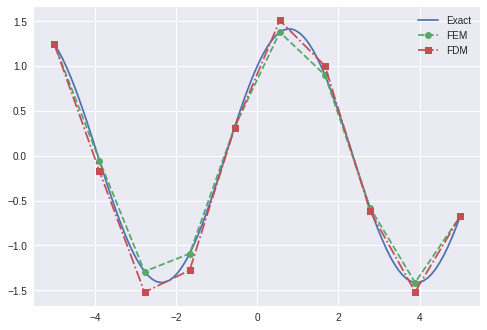

In [3]:
import sympy as sp
import numpy as np
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve

x = sp.Symbol('x') # global variable


# N discrete points of [a, b]
a, b, N = -5.0, 5.0, 10; 

# Compute the source based on a given exact solution
x = sp.Symbol('x')
ue = sp.sin(x)+ sp.cos(x)

f = -sp.diff(ue, x, 2);
lam_ue = sp.lambdify(x, ue, modules=['numpy'])
      
xd, u_fem = FEM(f, a, b, N, lam_ue)  

xd, u_fdm = FDM(f, a, b, N, lam_ue)  

xe = np.linspace(a, b, 100)
ue_fine = lam_ue(xe)

plt.plot(xe, ue_fine,'-',xd, u_fem,'--o',xd, u_fdm,'-.s')
plt.gca().legend(('Exact','FEM','FDM'))

Questions

*   Manipulate the number of grid points $N$ to compare the accuracy between the two methods
*   Manipulate the source $f$ (by changing the exact solution $u_e$) to compare the accuracy.
*   Modify the code for the quadratic basis functions.
*   Modify the code to solve $-u''+u = f$.